In [1]:
%config Completer.use_jedi = False


from torch.utils.data import Dataset
from tape.tokenizers import TAPETokenizer
from typing import List, Tuple, Any, Dict
import torch
from torch.utils.data import DataLoader, RandomSampler, Dataset
from tape.utils._sampler import BucketBatchSampler
from tape.datasets import pad_sequences
from tape import ProteinBertForValuePredictionFragmentationProsit
from prosittransformer.utils import cleanTapeOutput
from tqdm import tqdm
import pickle
import multiprocessing
import numpy as np

torch.multiprocessing.set_sharing_strategy('file_system')

In [48]:
import pickle
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['text.usetex'] = True


In [69]:
ceDataDict = pickle.load(open("./data/ceDataDict.pkl", "rb"))

In [71]:
class PrositFragmentationDataset(Dataset):

    def __init__(self,
                 data: dict,
                 ce: float):

        tokenizer = TAPETokenizer(vocab="iupac")
        self.tokenizer = tokenizer
        self.data = data
        self.ce = ce
        self.keys = [
                     'intensities_raw',
                     'collision_energy_aligned_normed',
                     'precursor_charge_onehot'
                     ]
                     
    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index: int):
        return self.data[index][:3] + tuple([np.array(self.ce, dtype=np.float32)]) + self.data[index][4:]

    def collate_fn(self, batch: List[Tuple[Any, ...]]) -> Dict[str, torch.Tensor]:
        input_ids, input_mask, intensities_raw_true_value, collision_energy, charge = tuple(zip(*batch))

        collision_energy = np.stack(collision_energy)
        input_ids = torch.from_numpy(pad_sequences(input_ids, 0))
        input_mask = torch.from_numpy(pad_sequences(input_mask, 0))
        intensities_raw_true_value = torch.FloatTensor(intensities_raw_true_value)  # type: ignore

        collision_energy_tensor = torch.FloatTensor(collision_energy)
        charge_tensor = torch.FloatTensor(charge)

        return {'input_ids': input_ids,
                'input_mask': input_mask,
                'targets': intensities_raw_true_value,
                'collision_energy': collision_energy_tensor,
                'charge': charge_tensor}

In [72]:
def getDataLoader(dataset: PrositFragmentationDataset)->DataLoader:
    sampler = RandomSampler(dataset)
    batch_sampler = BucketBatchSampler(sampler, 64, False, lambda x: len(x[0]), dataset)
    loader = DataLoader(
            dataset,
            num_workers=multiprocessing.cpu_count() - 2,
            collate_fn=dataset.collate_fn,  # type: ignore
            batch_sampler=batch_sampler)
    return loader

def getModel()->ProteinBertForValuePredictionFragmentationProsit:
    pytorch_model = ProteinBertForValuePredictionFragmentationProsit.from_pretrained("/sdd/berzelius/torch_model")
    pytorch_model = pytorch_model.to(torch.device('cuda:0'))
    return pytorch_model


In [73]:
pytorch_model = getModel()

In [74]:
CTO = cleanTapeOutput()

In [75]:
def getSa(model, loader)->float:
    sa_list = list()
    for i, batch in tqdm(enumerate(loader), total=len(loader)):  
        batch = {name: tensor.cuda(device=torch.device('cuda:0'), non_blocking=True)
                     for name, tensor in batch.items()}

        targets = batch["targets"].cpu().detach().numpy()
        charge = batch["charge"].cpu().detach().numpy()
        sequence = batch["input_ids"].cpu().detach().numpy()
        predictions = model(**batch)[1].cpu().detach().numpy()



        sa, _ = CTO.getIntensitiesAndSpectralAngle(predictions, targets, charge, sequence, True)
        sa_list.append(sa)

        if i == 3:
            break
    
    return np.median(np.concatenate(sa_list))


In [76]:
def getCeCalibSeries(model, data, range_x):
    sa_list = list()
    for i in range_x:
        dataset = PrositFragmentationDataset(data, round(i,2))
        loader = getDataLoader(dataset)
        sa_list.append(getSa(model, loader))
    return sa_list

In [77]:
R = np.linspace(0.10,0.7,61)

In [86]:
ceDataDict.keys()

dict_keys([0.25, 0.3, 0.35, 0.4, 0.45, 0.5])

In [88]:
ceDataDict[0.5]

[]

In [64]:
#SA_list, R_list, CE_list = list(), list(), list()
data_points = list()
for ce in list(ceDataDict.keys()):
    CE_DATA = ceDataDict[ce]
    sa_list = getCeCalibSeries(pytorch_model, CE_DATA, R)
    
    for s, r in zip(sa_list, R):
        data_points.append([s,r, ce])


  0%|          | 3/650 [00:00<01:04,  9.97it/s]


  1%|          | 3/381 [00:00<00:33, 11.38it/s]


ValueError: num_samples should be a positive integer value, but got num_samples=0

In [65]:
import pandas as pd

In [66]:
df = pd.DataFrame(data_points, columns=["sa", "ce", "CE"])

In [85]:
df

,sa,ce,CE
0,0.844831,0.10,0.25
1,0.849177,0.11,0.25
2,0.841241,0.12,0.25
3,0.815053,0.13,0.25
4,0.882520,0.14,0.25
...,...,...,...
239,0.897386,0.66,0.40
240,0.904550,0.67,0.40
241,0.908505,0.68,0.40
242,0.886718,0.69,0.40


In [80]:
fs=16 + 5

(array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

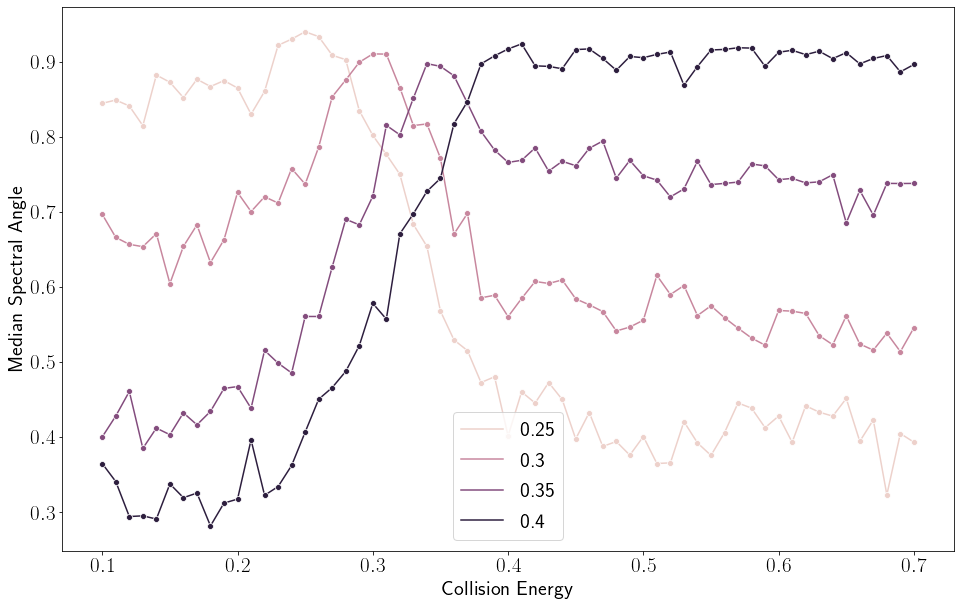

In [84]:
plt.figure(figsize=(16, 10))
ax = seaborn.lineplot(x="ce", y="sa", marker="o", hue="CE", data = df)
legend = ax.legend(handles=ax.legend_.legendHandles,
                   prop={"size":fs})


#plt.legend.get_title().set_fontsize('6')
#plt.rcParams['legend.title_fontsize'] = fs
plt.xlabel("Collision Energy", fontsize=fs)
plt.ylabel("Median Spectral Angle", fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

#plt.locator_params(axis='y', nbins=5)
#plt.locator_params(axis='x', nbins=6)

#plt.savefig("./compare.png")

In [ ]:
CTO = cleanTapeOutput()

In [ ]:
targets = np.concatenate(targets)
charge = np.concatenate(charge)
sequence = np.concatenate(sequence)
predictions = np.concatenate(predictions)

In [ ]:
sa, _ = CTO.getIntensitiesAndSpectralAngle(predictions, targets, charge, sequence, True)

In [ ]:
%config Completer.use_jedi = False

import numpy as np
from tqdm import tqdm

In [ ]:
from tape.datasets import PrositFragmentationDataset

In [ ]:
PrositData = PrositFragmentationDataset("/sdd/PrositToTapeDataConverter/LMDB", "test")

In [ ]:
x = {
    0.25 : [],
    0.3 : [],
    0.35 : [],
    0.4 : [],
    0.45 : [],
    0.5 : []
}

In [ ]:
def getCEdata(ceDataDict:dict, Dataset: PrositFragmentationDataset)->dict:
    #Loop each element in dataset
    for i in tqdm(range(len(Dataset))):
        for k in ceDataDict.keys():
            if np.round(Dataset[i][3], 2) == np.array(k, dtype=np.float32):
                ceDataDict[k].append(Dataset[i])
    return ceDataDict


In [ ]:
from torch.utils.data import Dataset
from tape.tokenizers import TAPETokenizer
from typing import List, Tuple, Any, Dict
import torch

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, Dataset
from tape.utils._sampler import BucketBatchSampler

In [ ]:
class PrositFragmentationDataset(Dataset):

    def __init__(self,
                 data: dict,
                 ce: float):

        tokenizer = TAPETokenizer(vocab="iupac")
        self.tokenizer = tokenizer
        self.data = data
        self.ce = ce
        self.keys = [
                     'intensities_raw',
                     'collision_energy_aligned_normed',
                     'precursor_charge_onehot'
                     ]
                     
    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index: int):
        return self.data[index][:3] + tuple([np.array(self.ce, dtype=np.float32)]) + self.data[index][4:]

    def collate_fn(self, batch: List[Tuple[Any, ...]]) -> Dict[str, torch.Tensor]:
        input_ids, input_mask, intensities_raw_true_value, collision_energy, charge = tuple(zip(*batch))

        collision_energy = np.stack(collision_energy)
        input_ids = torch.from_numpy(pad_sequences(input_ids, 0))
        input_mask = torch.from_numpy(pad_sequences(input_mask, 0))
        intensities_raw_true_value = torch.FloatTensor(intensities_raw_true_value)  # type: ignore

        collision_energy_tensor = torch.FloatTensor(collision_energy)
        charge_tensor = torch.FloatTensor(charge)

        return {'input_ids': input_ids,
                'input_mask': input_mask,
                'targets': intensities_raw_true_value,
                'collision_energy': collision_energy_tensor,
                'charge': charge_tensor}

In [ ]:
from tape.datasets import pad_sequences

In [ ]:
import pickle
import multiprocessing
#ceDataDict = getCEdata(x, PrositData)
#pickle.dump(ceDataDict, open("./data/ceDataDict.pkl", "wb"))

In [ ]:
ce25Dataset = PrositFragmentationDataset(ceDataDict[0.25], 0.3)

In [ ]:
ce25Dataset[0]

In [ ]:
sampler = RandomSampler(ce25Dataset)
batch_sampler = BucketBatchSampler(sampler, 64, False, lambda x: len(x[0]), ce25Dataset)
loader = DataLoader(
        ce25Dataset,
        num_workers=multiprocessing.cpu_count() - 1,
        collate_fn=ce25Dataset.collate_fn,  # type: ignore
        batch_sampler=batch_sampler)

In [ ]:
from tape import ProteinBertForValuePredictionFragmentationProsit

In [ ]:
pytorch_model = ProteinBertForValuePredictionFragmentationProsit.from_pretrained("/sdd/berzelius/torch_model")
if torch.cuda.is_available():
    use_gpu = True
    pytorch_model = pytorch_model.to(torch.device('cuda:0'))
else:
    use_gpu = False

In [ ]:
CTO = cleanTapeOutput()

In [ ]:
predictions = list()
targets = list()
for batch in tqdm(loader):  
    targets.append(batch["targets"].cpu().detach().numpy())
    if use_gpu:
        batch = {name: tensor.cuda(device=torch.device('cuda:0'), non_blocking=True)
                 for name, tensor in batch.items()}
    predictions.append(pytorch_model(**batch)[1].cpu().detach().numpy())
    break

In [ ]:
targets

In [ ]:
predictions

In [ ]:
CTO = cleanTapeOutput()

In [ ]:
CTO.

In [ ]:
pytorch_model = ProteinBertForValuePredictionFragmentationProsit.from_pretrained(model)
    if torch.cuda.is_available():
        use_gpu = True
        pytorch_model = pytorch_model.to(torch.device('cuda:0'))
    else:
        use_gpu = False
   
    loader = getTorchDataLoader(lmdb, split, batch_size = batch_size)
    predictions = list()
    for batch in tqdm(loader):  
        if use_gpu:
            batch = {name: tensor.cuda(device=torch.device('cuda:0'), non_blocking=True)
                     for name, tensor in batch.items()}
        predictions.append(pytorch_model(**batch)[1].cpu().detach().numpy())
    predictions = np.concatenate(predictions)

In [ ]:
for b in loader:
    break

In [ ]:
b

In [ ]:

    batch_sampler = BucketBatchSampler(
        sampler, batch_size, False, lambda x: len(x[0]), dataset)

    loader = DataLoader(
        dataset,
        num_workers=num_workers,
        collate_fn=dataset.collate_fn,  # type: ignore
        batch_sampler=batch_sampler)

In [ ]:
ceDataDict[0.25][0][:3] + tuple([np.array(0.3, dtype=np.float32)]) + ceDataDict[0.25][0][4:]

In [ ]:
ceDataDict[0.25][0][4:]

In [ ]:
([np.array(0.3, dtype=np.float32)])

In [ ]:
x == np.array(0.32, dtype=np.float32)

In [ ]:
np.round(TEST[0][3], 2)